In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import os
import nibabel as nib
import torch.nn.functional as F
import seaborn as sns
from models.unet import UNet
from datasets.BRATS2018 import NormalizeBRATS, ToTensor

%matplotlib inline

In [2]:
def visualize(model_path, device, base_path, img_name):
    """
    Plot the original image, predicted dense labels and the ground-true labels.
    Parameters:
    - model: PyTorch model
    - base_path: path to the augmented Pascal VOC dataset
    - img_name: image file name without format extension
                e.g. 2008_000073 is the img_path for 2008_000073.jpg and 2008_000073.mat
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 20))
    brats_colors = [[0, 0, 0], [192, 132, 0], [132, 0, 192], [0, 192, 132]]
    brats_classes = ['background', 'necrotic tumor', 'peritumoral edema', 'enhancing tumor']
    
    scan_path = os.path.join(base_path, img_name + '_scan.npy')
    gt_path = os.path.join(base_path, img_name + '_seg.npy')
    
    ind2color = {}
    legend_elements = []
    for ind, color in enumerate(brats_colors):
        ind2color[ind] = (color, brats_classes[ind])
        legend_elements.append(Line2D([0], [0], color=np.array(color)/255, lw=6))
    
    ax1.set_title('original image')
    sc = np.load(scan_path)
    gt = np.load(gt_path)
    assert sc.shape == (4, 240, 240)
    assert gt.shape == (240, 240)
    ax1.imshow(sc[1])
    
    model = UNet(4, 4, residual=True, expansion=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    normalize_brats = NormalizeBRATS()
    to_tensor = ToTensor()
    
    sc, gt = normalize_brats((sc, gt))
    sc, gt = to_tensor((sc, gt))
    
    sc = sc.to(device)
    gt = gt.to(device)
    
    # unsqueeze to 4 dimension NxCxHxW
    sc = torch.unsqueeze(sc, dim=0)
    with torch.no_grad():
        output = model(sc)
        pred = torch.argmax(F.softmax(output, dim=1), dim=1, keepdim=True)
    
    # squeeze back to 2 dimension HxW
    pred = torch.squeeze(pred)
    
    gt = gt.cpu().numpy()
    pred = pred.cpu().numpy()
    
    height, width = pred.shape
    colored_pred = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_pred[h, w] = ind2color[pred[h, w]][0]
            
    ax2.set_title('predicted feature map')
    ax2.imshow(colored_pred)
    
    height, width = gt.shape
    colored_gt = np.zeros((height, width, 3), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            colored_gt[h, w] = ind2color[gt[h, w]][0]
    
    ax3.set_title('ground true dense label')
    ax3.legend(handles=legend_elements, labels=brats_classes, loc='upper center', bbox_to_anchor=(1.5, 1.2))
    ax3.imshow(colored_gt)
    

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [15]:
!ls BRATS2018/SEG_LGG/val/

Brats18_TCIA13_618_1_020_et.npy    Brats18_TCIA13_634_1_020_et.npy
Brats18_TCIA13_618_1_020_scan.npy  Brats18_TCIA13_634_1_020_scan.npy
Brats18_TCIA13_618_1_020_seg.npy   Brats18_TCIA13_634_1_020_seg.npy
Brats18_TCIA13_618_1_020_tc.npy    Brats18_TCIA13_634_1_020_tc.npy
Brats18_TCIA13_618_1_020_wt.npy    Brats18_TCIA13_634_1_020_wt.npy
Brats18_TCIA13_618_1_021_et.npy    Brats18_TCIA13_634_1_021_et.npy
Brats18_TCIA13_618_1_021_scan.npy  Brats18_TCIA13_634_1_021_scan.npy
Brats18_TCIA13_618_1_021_seg.npy   Brats18_TCIA13_634_1_021_seg.npy
Brats18_TCIA13_618_1_021_tc.npy    Brats18_TCIA13_634_1_021_tc.npy
Brats18_TCIA13_618_1_021_wt.npy    Brats18_TCIA13_634_1_021_wt.npy
Brats18_TCIA13_618_1_022_et.npy    Brats18_TCIA13_634_1_022_et.npy
Brats18_TCIA13_618_1_022_scan.npy  Brats18_TCIA13_634_1_022_scan.npy
Brats18_TCIA13_618_1_022_seg.npy   Brats18_TCIA13_634_1_022_seg.npy
Brats18_TCIA13_618_1_022_tc.npy    Brats18_TCIA13_634_1_022_tc.npy
Brats18_TCIA13_618_1_022_wt.npy    Brats18_TCIA13_634

Brats18_TCIA13_621_1_116_tc.npy    Brats18_TCIA13_642_1_116_tc.npy
Brats18_TCIA13_621_1_116_wt.npy    Brats18_TCIA13_642_1_116_wt.npy
Brats18_TCIA13_621_1_117_et.npy    Brats18_TCIA13_642_1_117_et.npy
Brats18_TCIA13_621_1_117_scan.npy  Brats18_TCIA13_642_1_117_scan.npy
Brats18_TCIA13_621_1_117_seg.npy   Brats18_TCIA13_642_1_117_seg.npy
Brats18_TCIA13_621_1_117_tc.npy    Brats18_TCIA13_642_1_117_tc.npy
Brats18_TCIA13_621_1_117_wt.npy    Brats18_TCIA13_642_1_117_wt.npy
Brats18_TCIA13_621_1_118_et.npy    Brats18_TCIA13_642_1_118_et.npy
Brats18_TCIA13_621_1_118_scan.npy  Brats18_TCIA13_642_1_118_scan.npy
Brats18_TCIA13_621_1_118_seg.npy   Brats18_TCIA13_642_1_118_seg.npy
Brats18_TCIA13_621_1_118_tc.npy    Brats18_TCIA13_642_1_118_tc.npy
Brats18_TCIA13_621_1_118_wt.npy    Brats18_TCIA13_642_1_118_wt.npy
Brats18_TCIA13_621_1_119_et.npy    Brats18_TCIA13_642_1_119_et.npy
Brats18_TCIA13_621_1_119_scan.npy  Brats18_TCIA13_642_1_119_scan.npy
Brats18_TCIA13_621_1_119_seg.npy   Brats18_TCIA13_642_

/home/martin/Documents/semantic_segmentation/PyTorch_venv/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


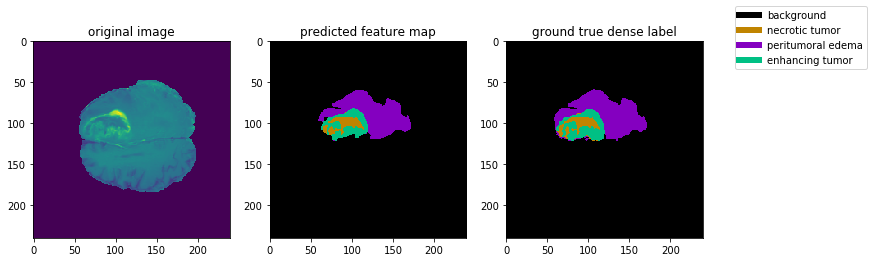

In [4]:
visualize(model_path='../UNet-ResidualBlock-Expansion_210_end_to_end_manual/UNet-ResidualBlock-Expansion-BRATS2018-End-to-End_batch6_training_epochs15_Adam_scheduler-step10-gamma1.0_lr5e-05_w_decay3e-05/trained_model.pt',
         device=device, base_path='BRATS2018/SEG_HGG/val/', img_name='Brats18_TCIA06_372_1_099')

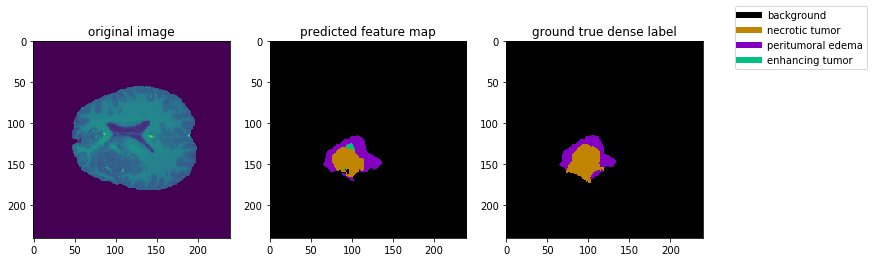

In [5]:
visualize(model_path='../UNet-ResidualBlock-Expansion_LGG_end_to_end/epoch10_model.pt',\
          device=device,
          base_path='BRATS2018/SEG_LGG/val/', img_name='Brats18_TCIA13_634_1_088')